In [1]:
import scanpy as sc
import os
import rapids_singlecell as rsc
import cfp
import functools
import os
import sys
import traceback
from typing import Dict, Literal, Optional, Tuple
import cfp
import scanpy as sc
import numpy as np
import functools
from ott.solvers import utils as solver_utils
import optax
from omegaconf import OmegaConf
from typing import NamedTuple, Any
import hydra
import wandb
import anndata as ad
import pandas as pd
import os
from cfp.training import ComputationCallback
from cfp.preprocessing import transfer_labels, compute_wknn
from cfp.training import ComputationCallback
from numpy.typing import ArrayLike
from cfp.metrics import compute_r_squared, compute_e_distance
from scipy.stats import percentileofscore

sc.set_figure_params(dpi_save=400)

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish_new/zebrafish_processed.h5ad")

In [8]:
ood_cond = "cdx4_cdx1a_36"
gene_target = "_".join(ood_cond.split("_")[:2])
wandb_name = "lucky-voice-7"

In [4]:
control_key = "is_control"
adata_ctrl = adata[adata.obs[control_key].to_numpy()]
covariate_data = adata[adata.obs["gene_target"]==gene_target].obs.drop_duplicates(subset=["condition"])
    

In [5]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/zebrafish/depletion_analysis"
fig_dir = "/lustre/groups/ml01/workspace/ot_perturbation/figures/zebrafish/depletion_analysis"

In [6]:
def compute_depletion(adata, num_shuffles = 1000, significance_threshold=5.0):
    binary_adj = adata.obsp['distances'] > 0
    is_perturbed = adata.obs["numerical_mode"].values
    neighbors_perturbed = binary_adj @ is_perturbed 

    rng = np.random.default_rng(0)
    null = []
    for i in range(1000):
        rng.shuffle(is_perturbed)
        null.append(binary_adj @ is_perturbed)
        
    null_vals = np.vstack(null)
    
    percentiles = []
    for i in range(len(neighbors_perturbed)):
        percentiles.append(percentileofscore(null_vals[:,i], neighbors_perturbed[i], kind='rank'))

    adata.obs["percentiles"] = percentiles
    adata.obs["is_significantly_depleted"] = adata.obs.apply(lambda x: "True" if x["percentiles"]<significance_threshold else "False", axis=1)


In [9]:
adata_pred=sc.read_h5ad(f"/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish_new/depletion_analysis/{wandb_name}_36_preds_50k.h5ad")
adata_pred.obs["timepoint"] = adata_pred.obs.apply(lambda x: x["condition"].split("_")[-1], axis=1)
adata_pred.obs["gene_target"] = adata_pred.obs['condition'].str.split('_').str[:2].str.join('_')
adata_pred.obs["mode"] = "pred"
adata_pred.obs["gene_target"].value_counts()

gene_target
cdx4_cdx1a    100000
Name: count, dtype: int64

In [10]:
adata_true = adata[adata.obs["condition"]=="cdx4_cdx1a_36"]
adata_true.obs["mode"] = "true"
adata_true.obs["timepoint"].value_counts()


/tmp/ipykernel_1329633/2883173722.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_true.obs["mode"] = "true"


timepoint
36.0    25779
Name: count, dtype: int64

In [11]:
control_key = "is_control"
adata_ctrl = adata[adata.obs[control_key].to_numpy()]
adata_ctrl_36 = adata_ctrl[adata_ctrl.obs["timepoint"]==36]
adata_ctrl_36.obs["mode"] = "control"
covariate_data = adata[adata.obs["gene_target"]==gene_target].obs.drop_duplicates(subset=["condition"])
covariate_data_36 = covariate_data[covariate_data["timepoint"]==36]

/tmp/ipykernel_1329633/2669503065.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ctrl_36.obs["mode"] = "control"


In [12]:
bdata = ad.concat((adata_true, adata_pred, adata_ctrl_36))

In [13]:
bdata.obs = bdata.obs.reset_index()

In [14]:
bdata.obs["timepoint"].value_counts()

timepoint
36.0    184343
36      100000
Name: count, dtype: int64

In [15]:
from cfp.preprocessing import transfer_labels, compute_wknn
compute_wknn(ref_adata=adata, query_adata=bdata, n_neighbors=1, ref_rep_key="X_aligned", query_rep_key="X_aligned")
transfer_labels(query_adata=bdata, ref_adata=adata, label_key="cell_type_broad")
        

In [19]:
bdata.obs["timepoint"] = bdata.obs["timepoint"].astype(int)

In [21]:
bdata.write_h5ad(f"/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish_new/depletion_analysis/{wandb_name}_36_preds_50k_with_labels_transferred.h5ad")

# Plot UMAP

In [102]:
cdata = adata[adata.obs["condition"]=="control_control_36"]
rsc.pp.neighbors(cdata, use_rep="X_aligned")
rsc.tl.umap(cdata, min_dist=1.1)

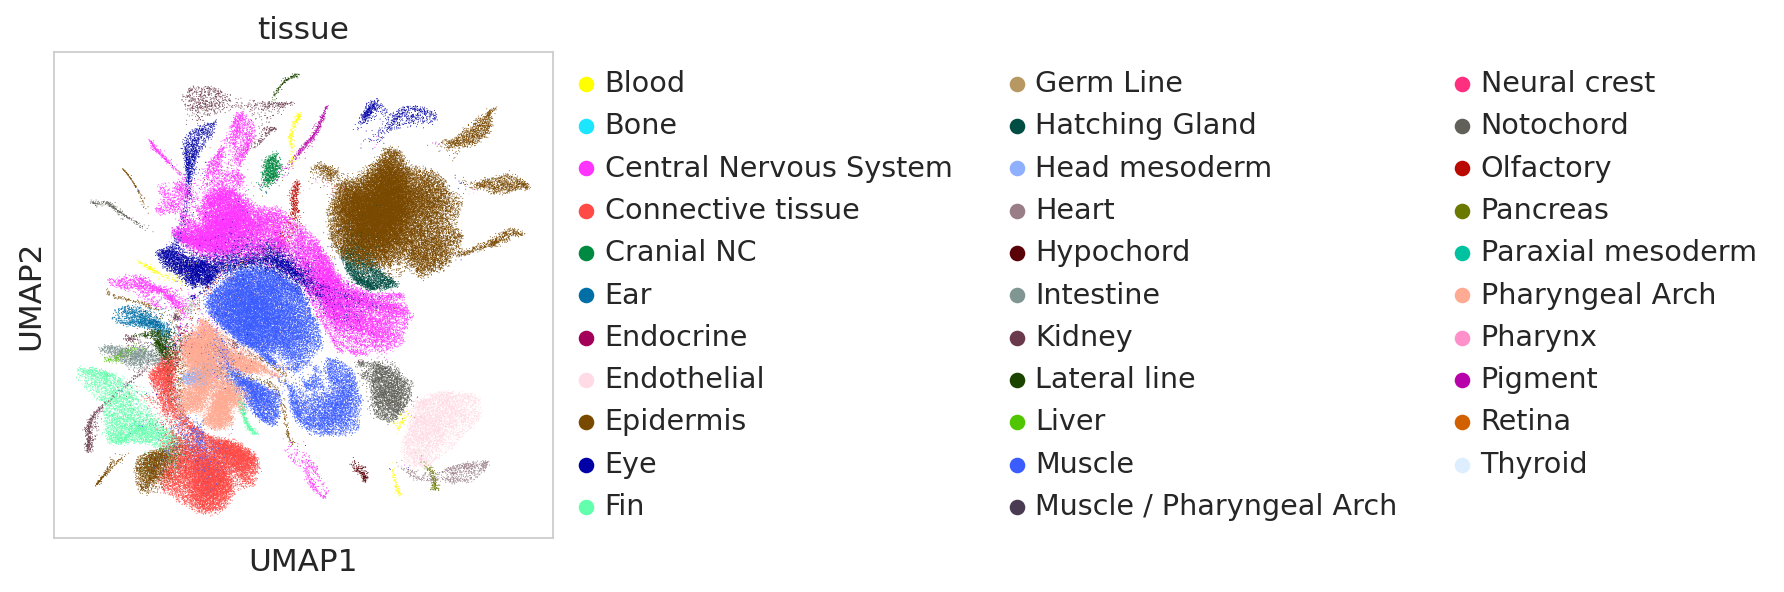

In [103]:
sc.pl.umap(cdata, color="tissue")

In [104]:

color_dict = {ct: "#B6B6B6" for ct in cdata.obs["cell_type_broad"].unique()}
color_dict2 = {'neural progenitor (hindbrain)': "#FAD09F", 
             'neural progenitor (hindbrain R7/8)': "#885578",
             'differentiating neuron (hindbrain)': "#809693",
             'neural progenitor (telencephalon/diencephalon)': "#FF95A4",
             'basal cell': "#232E21",
             'connective tissue-meninges-dermal FB': "#582B36",
             'pectoral fin bud (osteoblast+)': "#8C284A",
             'fin fold': "#F42272",
             'head/eye connective tissue': "#F397D6",
             'fin bud mesoderm (pectoral)': "#F397D6",
             'fin mesenchyme': "#D7B8F3",
             'neural tube-like connective tissue (+ taste bud)': "#B8B8F3",
             'contains head vasculature?': "#81A292",
              'mature fast muscle': "#7A7978",
             'mature slow muscle':"#81A292",
             'anterior migratory muscle':"#87CBAC",
             'fast-committed myocyte (fusing)':"#90FFDC",
             'cranial muscle (non-somitic, fast-twitch)':"#8FF2EE",
             'unknown (dcn+, col6+)': "#8DE4FF",
             'fast-committed myocyte (pre-fusion)':"#8AC4FF",
             'satellite cells':"#035E7B",
             'myoblast':"#024654",
             'slow-committed myocyte':"#002E2C",
             }

color_dict.update(color_dict2)
cts_to_visualize = list(color_dict2.keys())

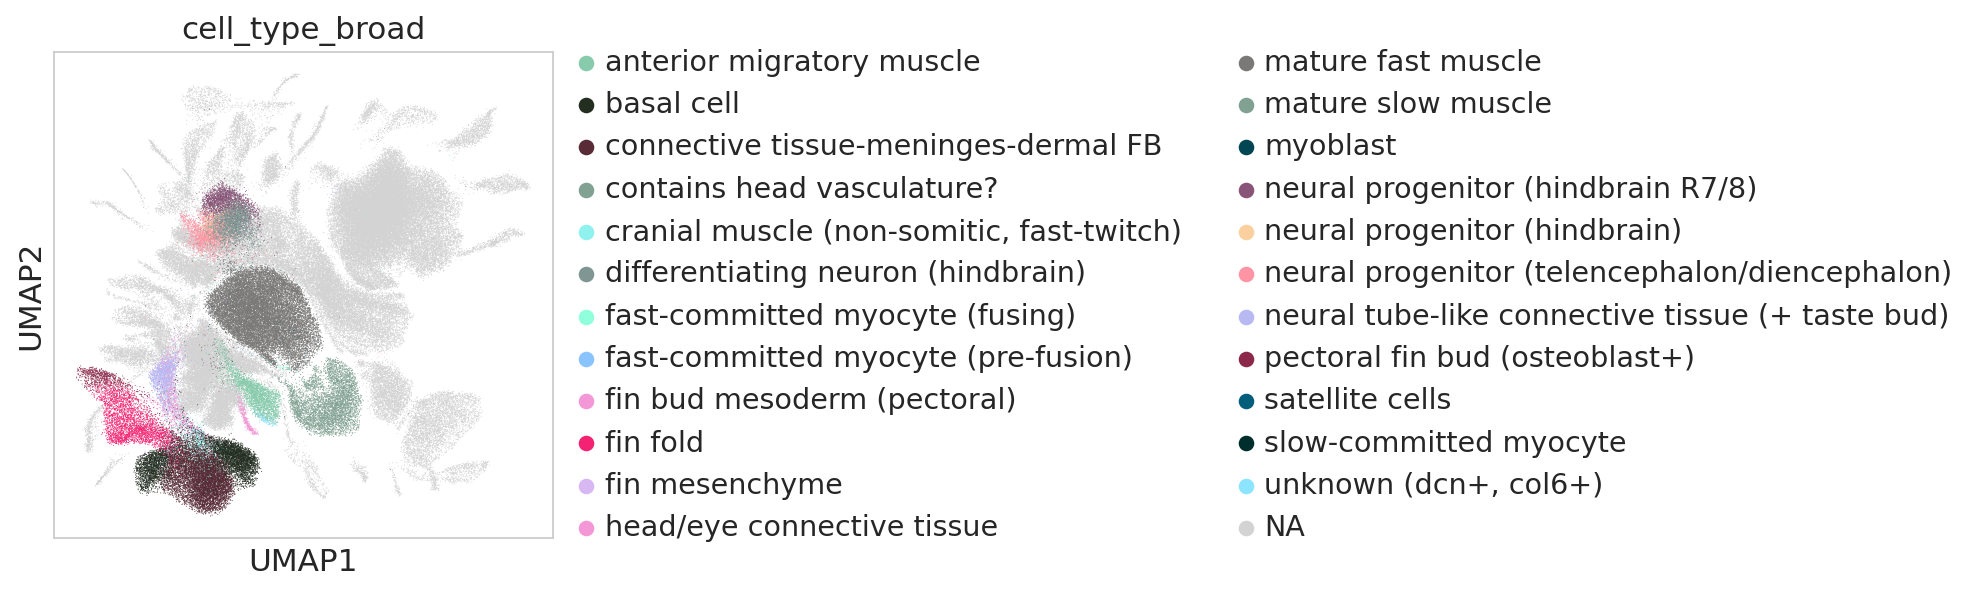

In [105]:
fig = sc.pl.umap(cdata, color="cell_type_broad", groups=cts_to_visualize, palette=color_dict, return_fig=True)
fig.savefig(os.path.join(fig_dir, "umap_control_cell_types_selected.png"))

# Neural progenitors

In [106]:
cell_types_selection = ["neural progenitor (hindbrain)", "neural progenitor (hindbrain R7/8)", "differentiating neuron (hindbrain)", "neural progenitor (telencephalon/diencephalon)"]



In [107]:
bdata_selection = bdata[(bdata.obs["cell_type_broad_transfer"].isin(cell_types_selection))]
bdata_selection.obs = bdata_selection.obs.reset_index()

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [108]:

bdata_selection.obs["mode"] = bdata_selection.obs["mode"].astype(str)

# Get minimum sample count for downsampling
downsample_to = bdata_selection.obs["mode"].value_counts().reindex(["pred", "true"], fill_value=0).min()

# Proper indexing for AnnData (use boolean mask on .obs index)
bdata_selection_ctrl = bdata_selection[bdata_selection.obs["mode"] == "control"].copy()
bdata_selection_true = bdata_selection[bdata_selection.obs["mode"] == "true"].copy()
bdata_selection_pred = bdata_selection[bdata_selection.obs["mode"] == "pred"].copy()

# Subsample only if necessary
if bdata_selection_pred.n_obs > downsample_to:
    bdata_selection_pred = sc.pp.subsample(bdata_selection_pred, n_obs=downsample_to, copy=True)

if bdata_selection_true.n_obs > downsample_to:
    bdata_selection_true = sc.pp.subsample(bdata_selection_true, n_obs=downsample_to, copy=True)

bdata_selection_ctrl_true = ad.concat([bdata_selection_ctrl, bdata_selection_true])
bdata_selection_ctrl_pred = ad.concat([bdata_selection_ctrl, bdata_selection_pred])

rsc.pp.neighbors(bdata_selection_ctrl_true, use_rep="X_aligned")
rsc.pp.neighbors(bdata_selection_ctrl_pred, use_rep="X_aligned")

rsc.tl.umap(bdata_selection_ctrl_true)
rsc.tl.umap(bdata_selection_ctrl_pred)

bdata_selection_ctrl_true.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_true.obs["mode"] == "control", 0.0, 1.0
)
bdata_selection_ctrl_pred.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_pred.obs["mode"] == "control", 0.0, 1.0
)


/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [109]:
compute_depletion(bdata_selection_ctrl_pred)
compute_depletion(bdata_selection_ctrl_true)
bdata_selection_ctrl_pred.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_pred.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)
bdata_selection_ctrl_true.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_true.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)

In [110]:
df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_pred = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_pred[ct] = frac_depleted.values



df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_true = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_true[ct] = frac_depleted.values


/tmp/ipykernel_1329633/1086478450.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
/tmp/ipykernel_1329633/1086478450.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_s

In [111]:
df_depletion_fracs = pd.DataFrame.from_dict(df_depletion_frac_true, columns=["true"], orient="index")
df_depletion_fracs["pred"] = pd.DataFrame.from_dict(df_depletion_frac_pred, columns=["pred"], orient="index")["pred"]
df_depletion_fracs

true      pred
differentiating neuron (hindbrain)              0.135399  0.078814
neural progenitor (hindbrain R7/8)              0.269569  0.167319
neural progenitor (hindbrain)                   0.031100  0.040670
neural progenitor (telencephalon/diencephalon)  0.090696  0.038034

In [112]:
df_depletion_fracs.to_csv(os.path.join(output_dir, "depletion_fracs_neuron_progenitors.csv"))

In [113]:
df_depl_normalized = df_depletion_fracs/df_depletion_fracs.mean(axis=0)
df_depl_normalized

true      pred
differentiating neuron (hindbrain)              1.028155  0.970510
neural progenitor (hindbrain R7/8)              2.046979  2.060343
neural progenitor (hindbrain)                   0.236162  0.500803
neural progenitor (telencephalon/diencephalon)  0.688704  0.468345

In [114]:
rsc.pp.neighbors(bdata_selection_ctrl, use_rep="X_aligned")
rsc.tl.umap(bdata_selection_ctrl)

In [115]:
bdata_selection_ctrl.obs["depletion_true"] = bdata_selection_ctrl_true.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_pred"] = bdata_selection_ctrl_pred.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_scores_true"] = bdata_selection_ctrl_true.obs["percentiles"]
bdata_selection_ctrl.obs["depletion_scores_pred"] = bdata_selection_ctrl_pred.obs["percentiles"]

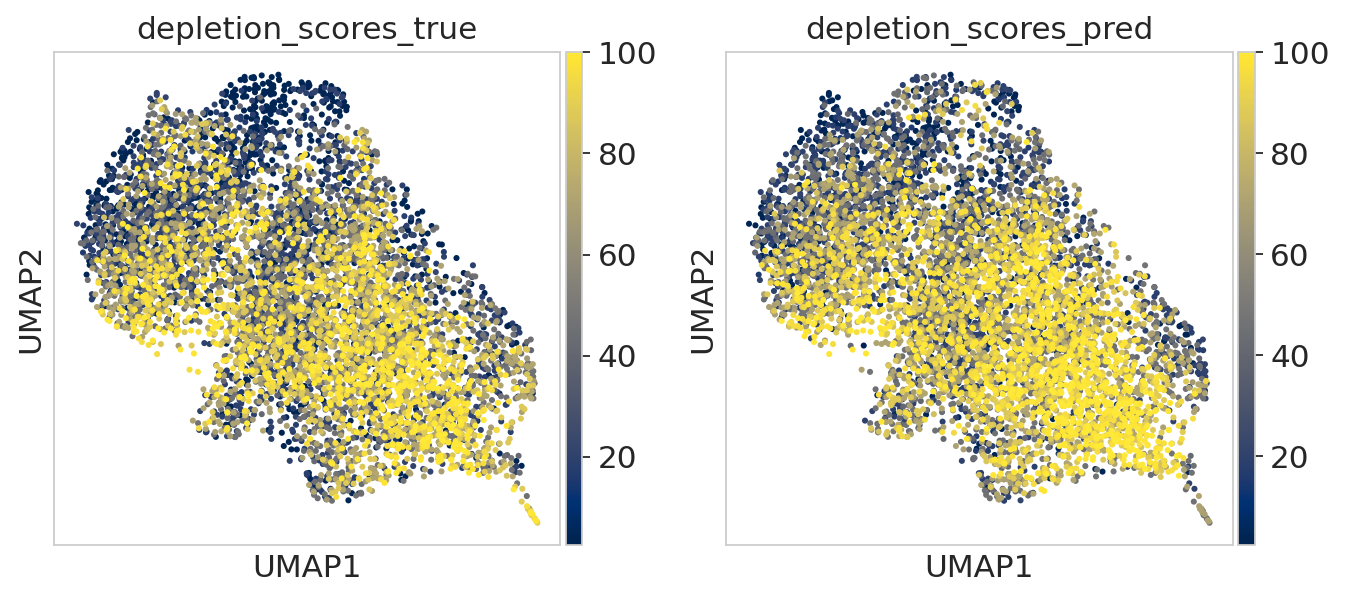

In [116]:
fig = sc.pl.umap(
    bdata_selection_ctrl, 
    s=30,
    color=["depletion_scores_true", "depletion_scores_pred"], 
    cmap="cividis",  
    return_fig=True
)

fig.savefig(os.path.join(fig_dir, "umap_depletion_neuronal_progs.png"))


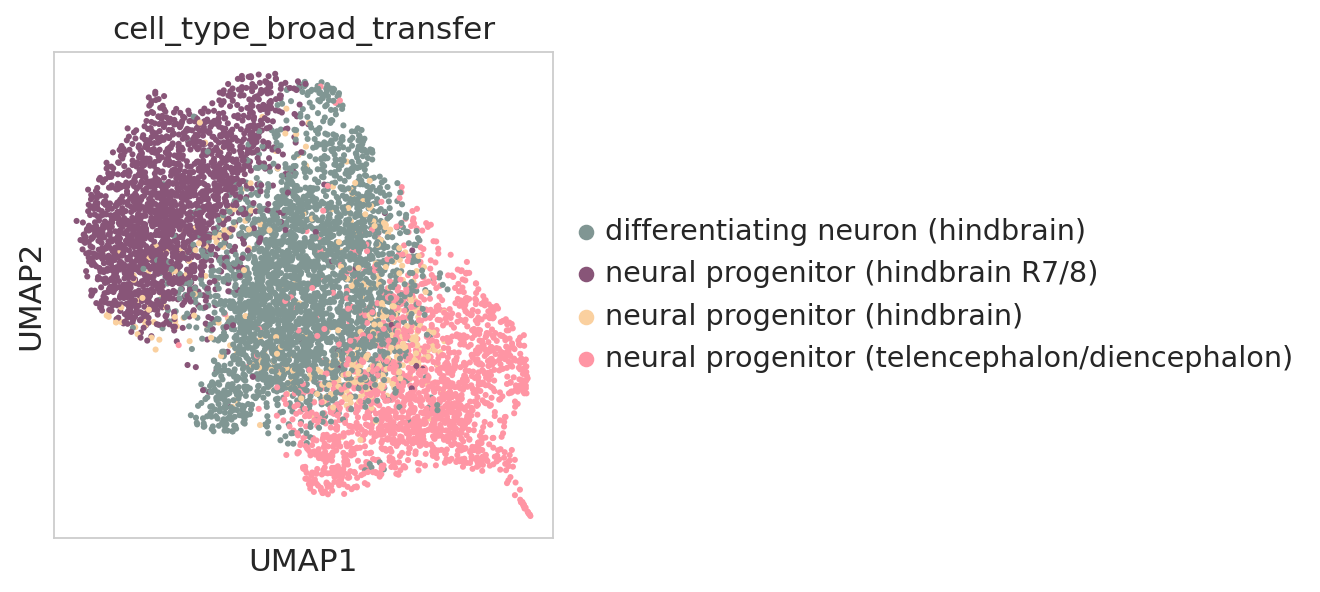

In [117]:
fig = sc.pl.umap(bdata_selection_ctrl, color=["cell_type_broad_transfer"], return_fig=True, s=30, palette=color_dict)
fig.savefig(os.path.join(fig_dir, "umap_depletion_brain_cell_types.png"))

In [118]:
bdata_selection_ctrl.obs[["depletion_scores_true", "depletion_scores_pred"]].corr()

depletion_scores_true  depletion_scores_pred
depletion_scores_true               1.000000               0.464808
depletion_scores_pred               0.464808               1.000000

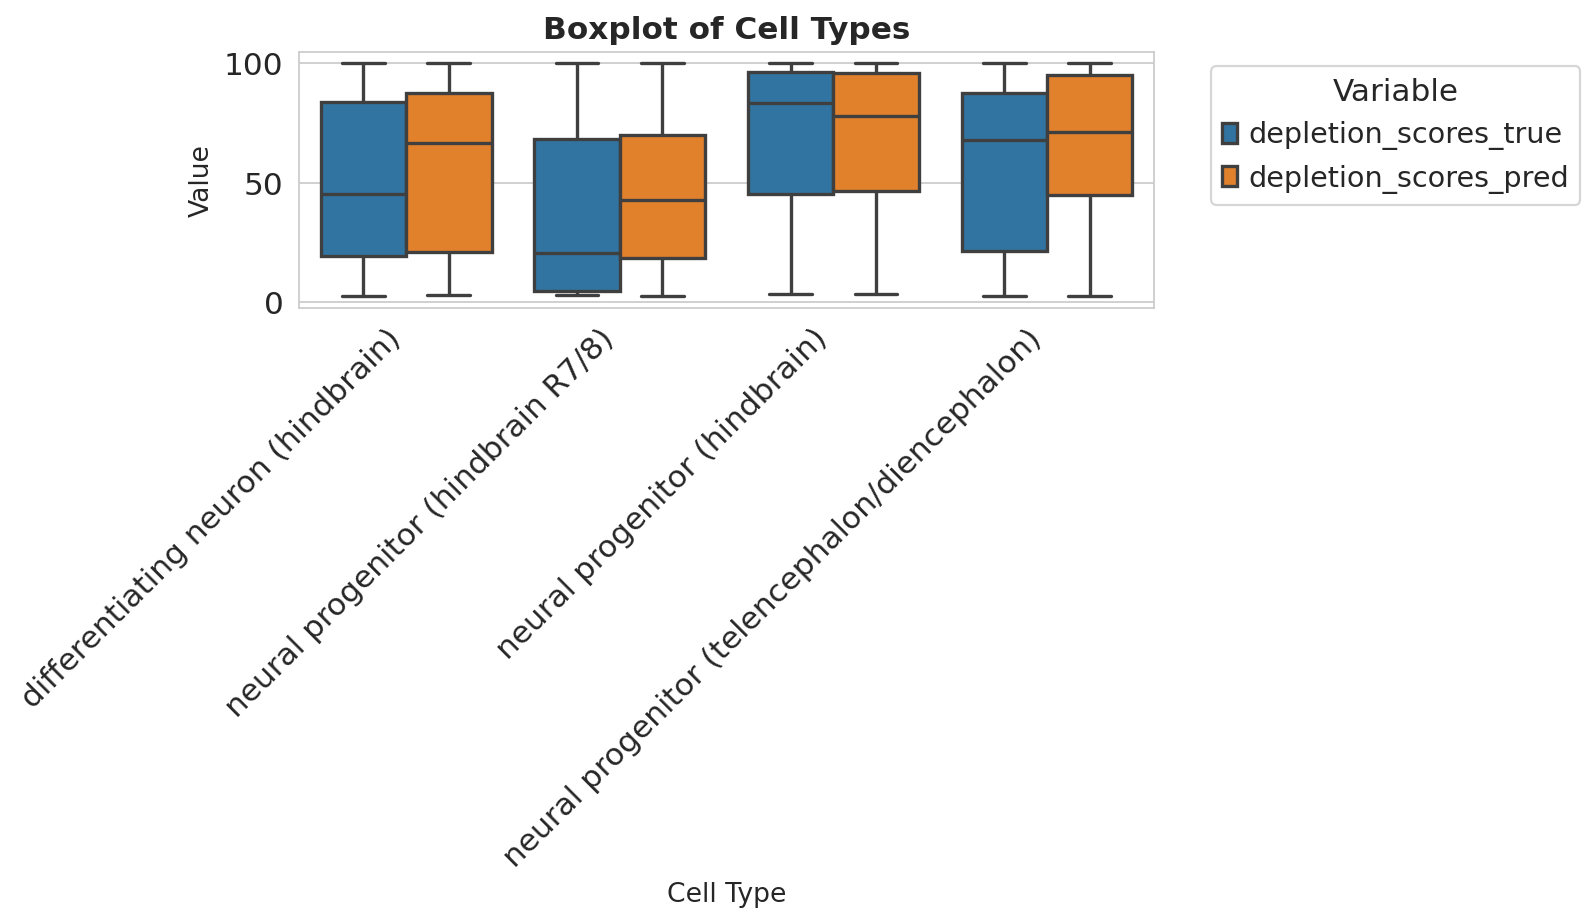

In [119]:
df_tmp = bdata_selection_ctrl.obs[["depletion_scores_true", "depletion_scores_pred", "cell_type_broad_transfer"]]
df_tmp = pd.melt(df_tmp, id_vars=["cell_type_broad_transfer"], value_vars=["depletion_scores_true", "depletion_scores_pred"])

# Set a better style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create the boxplot with enhancements
ax = sns.boxplot(
    data=df_tmp, 
    x="cell_type_broad_transfer", 
    y="value", 
    hue="variable",
    showfliers=False,  # Hide outliers for a cleaner look
    linewidth=1.5,  # Make box outlines slightly thicker
    dodge=True  # Separate the hues better
)

# Improve legend positioning
plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc="upper left")

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha="right")

# Improve axis labels and title
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Boxplot of Cell Types", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()


# Whole embryo

In [120]:
bdata_selection = bdata.copy()
bdata_selection.obs = bdata_selection.obs.reset_index()

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [121]:

bdata_selection.obs["mode"] = bdata_selection.obs["mode"].astype(str)

# Get minimum sample count for downsampling
downsample_to = bdata_selection.obs["mode"].value_counts().reindex(["pred", "true"], fill_value=0).min()

# Proper indexing for AnnData (use boolean mask on .obs index)
bdata_selection_ctrl = bdata_selection[bdata_selection.obs["mode"] == "control"].copy()
bdata_selection_true = bdata_selection[bdata_selection.obs["mode"] == "true"].copy()
bdata_selection_pred = bdata_selection[bdata_selection.obs["mode"] == "pred"].copy()

# Subsample only if necessary
if bdata_selection_pred.n_obs > downsample_to:
    bdata_selection_pred = sc.pp.subsample(bdata_selection_pred, n_obs=downsample_to, copy=True)

if bdata_selection_true.n_obs > downsample_to:
    bdata_selection_true = sc.pp.subsample(bdata_selection_true, n_obs=downsample_to, copy=True)

bdata_selection_ctrl_true = ad.concat([bdata_selection_ctrl, bdata_selection_true])
bdata_selection_ctrl_pred = ad.concat([bdata_selection_ctrl, bdata_selection_pred])

rsc.pp.neighbors(bdata_selection_ctrl_true, use_rep="X_aligned")
rsc.pp.neighbors(bdata_selection_ctrl_pred, use_rep="X_aligned")

rsc.tl.umap(bdata_selection_ctrl_true)
rsc.tl.umap(bdata_selection_ctrl_pred)

bdata_selection_ctrl_true.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_true.obs["mode"] == "control", 0.0, 1.0
)
bdata_selection_ctrl_pred.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_pred.obs["mode"] == "control", 0.0, 1.0
)


/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [122]:
compute_depletion(bdata_selection_ctrl_pred)
compute_depletion(bdata_selection_ctrl_true)
bdata_selection_ctrl_pred.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_pred.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)
bdata_selection_ctrl_true.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_true.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)

In [123]:
df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_pred = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_pred[ct] = frac_depleted.values



df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_true = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_true[ct] = frac_depleted.values


/tmp/ipykernel_1329633/1086478450.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
/tmp/ipykernel_1329633/1086478450.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_s

In [124]:
df_depletion_fracs = pd.DataFrame.from_dict(df_depletion_frac_true, columns=["true"], orient="index")
df_depletion_fracs["pred"] = pd.DataFrame.from_dict(df_depletion_frac_pred, columns=["pred"], orient="index")["pred"]
df_depletion_fracs

true      pred
KA neuron                   0.019841  0.015873
adrenal gland               0.000000  0.000000
anterior migratory muscle   0.020247  0.012373
basal cell                  0.009636  0.006683
cardiomyocyte               0.006279  0.009419
...                              ...       ...
support cells/otic vesicle  0.004792  0.003994
thyroid follicle cell       0.016807  0.000000
unknown (dcn+, col6+)       0.052239  0.029851
vascular smooth muscle      0.000000  0.000000
xanthophore                 0.012063  0.010856

[96 rows x 2 columns]

In [157]:
sns.barplot(df_depletion_fracs, hue=["true", "pred"])

ValueError: The following variable cannot be assigned with wide-form data: `hue`

In [125]:
df_depletion_fracs.to_csv(os.path.join(output_dir, "depletion_fracs_full_embryo.csv"))

In [126]:
df_depl_normalized = df_depletion_fracs/df_depletion_fracs.mean(axis=0)
df_depl_normalized

true      pred
KA neuron                   1.595209  1.674941
adrenal gland               0.000000  0.000000
anterior migratory muscle   1.627867  1.305662
basal cell                  0.774745  0.705225
cardiomyocyte               0.504857  0.993921
...                              ...       ...
support cells/otic vesicle  0.385297  0.421411
thyroid follicle cell       1.351236  0.000000
unknown (dcn+, col6+)       4.199924  3.149889
vascular smooth muscle      0.000000  0.000000
xanthophore                 0.969826  1.145587

[96 rows x 2 columns]

In [127]:
rsc.pp.neighbors(bdata_selection_ctrl, use_rep="X_aligned")
rsc.tl.umap(bdata_selection_ctrl, min_dist=0.9)

In [128]:
bdata_selection_ctrl.obs["depletion_true"] = bdata_selection_ctrl_true.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_pred"] = bdata_selection_ctrl_pred.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_scores_true"] = bdata_selection_ctrl_true.obs["percentiles"]
bdata_selection_ctrl.obs["depletion_scores_pred"] = bdata_selection_ctrl_pred.obs["percentiles"]


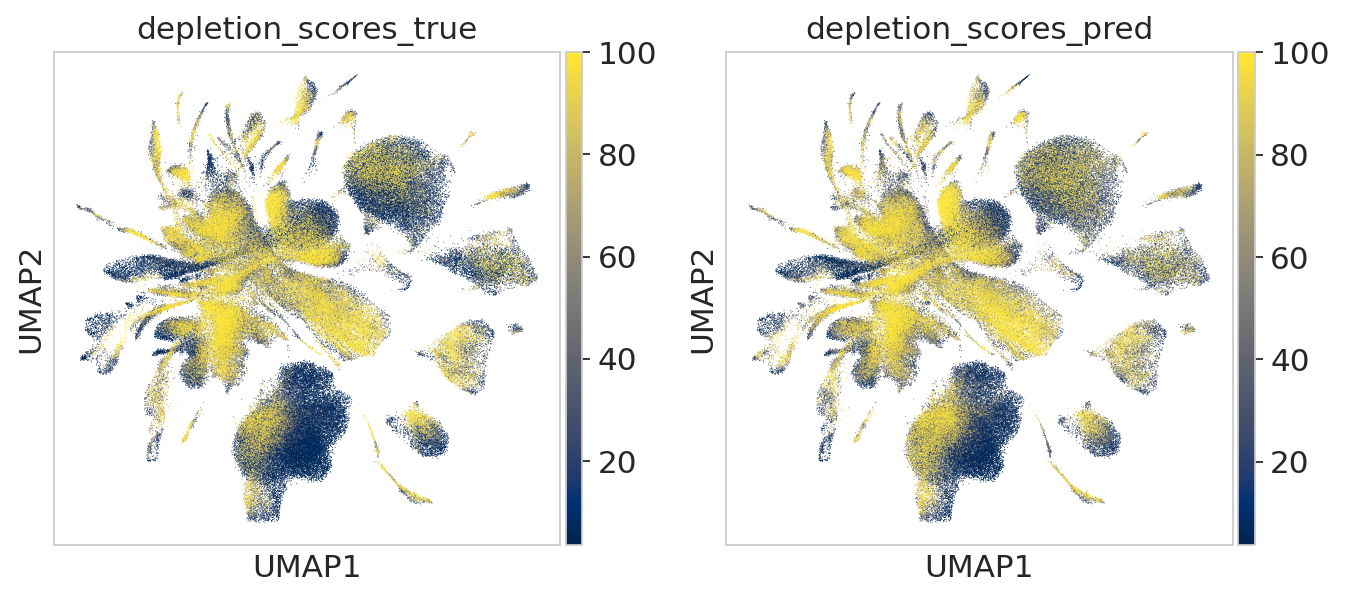

In [129]:

fig = sc.pl.umap(bdata_selection_ctrl, color=["depletion_scores_true", "depletion_scores_pred"], cmap="cividis", return_fig=True)
fig.savefig(os.path.join(fig_dir, "umap_depletion_whole_embryo.png"))

In [130]:
cdata.obs = bdata_selection_ctrl.obs.copy()

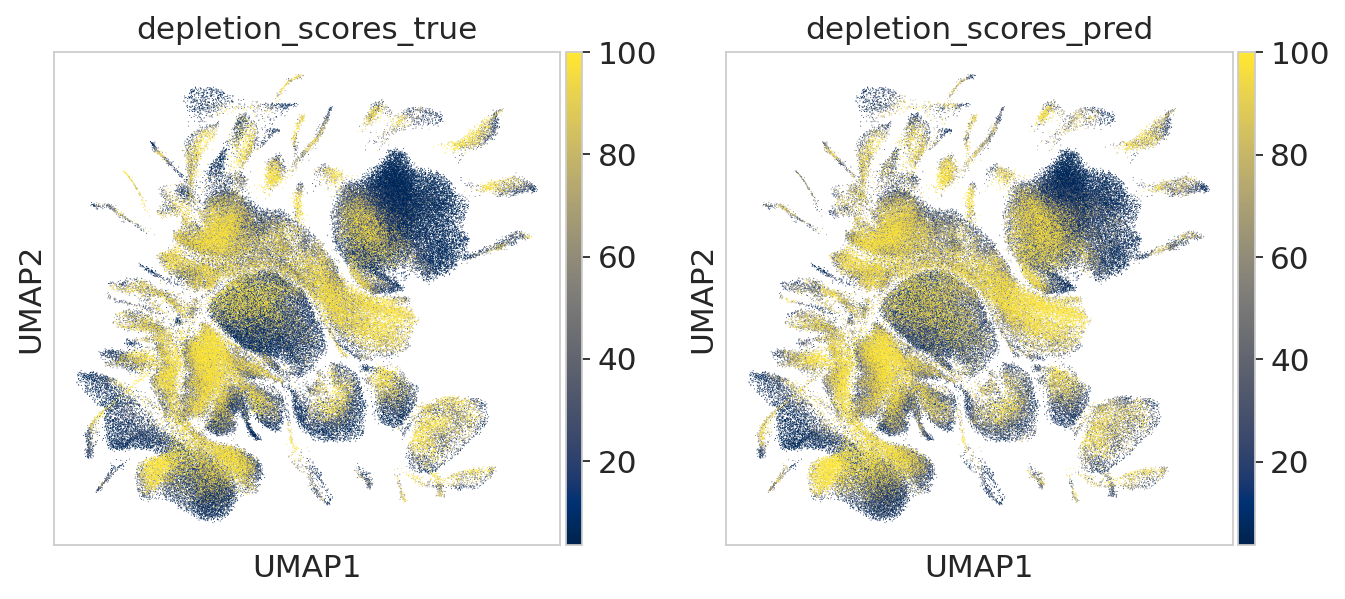

In [131]:
fig = sc.pl.umap(cdata, color=["depletion_scores_true", "depletion_scores_pred"], cmap="cividis", return_fig=True)
fig.savefig(os.path.join(fig_dir, "umap_depletion_whole_embryo_same_umap.png"))

In [132]:
bdata_selection_ctrl.obs[["depletion_scores_true", "depletion_scores_pred"]].corr()

depletion_scores_true  depletion_scores_pred
depletion_scores_true               1.000000               0.651168
depletion_scores_pred               0.651168               1.000000

# Fin

In [161]:
cts_to_keep = list(adata[adata.obs["tissue"].isin(("Connective tissue", "Fin"))].obs["cell_type_broad"].unique())

In [162]:
cts_to_keep 

['basal cell',
 'connective tissue-meninges-dermal FB',
 'pectoral fin bud (osteoblast+)',
 'fin fold',
 'head/eye connective tissue',
 'fin bud mesoderm (pectoral)',
 'fin mesenchyme',
 'neural tube-like connective tissue (+ taste bud)',
 'contains head vasculature?']

In [163]:
bdata_selection = bdata[bdata.obs["cell_type_broad_transfer"].isin(cts_to_keep)]
bdata_selection.obs = bdata_selection.obs.reset_index()

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [164]:

bdata_selection.obs["mode"] = bdata_selection.obs["mode"].astype(str)

# Get minimum sample count for downsampling
downsample_to = bdata_selection.obs["mode"].value_counts().reindex(["pred", "true"], fill_value=0).min()

# Proper indexing for AnnData (use boolean mask on .obs index)
bdata_selection_ctrl = bdata_selection[bdata_selection.obs["mode"] == "control"].copy()
bdata_selection_true = bdata_selection[bdata_selection.obs["mode"] == "true"].copy()
bdata_selection_pred = bdata_selection[bdata_selection.obs["mode"] == "pred"].copy()

# Subsample only if necessary
if bdata_selection_pred.n_obs > downsample_to:
    bdata_selection_pred = sc.pp.subsample(bdata_selection_pred, n_obs=downsample_to, copy=True)

if bdata_selection_true.n_obs > downsample_to:
    bdata_selection_true = sc.pp.subsample(bdata_selection_true, n_obs=downsample_to, copy=True)

bdata_selection_ctrl_true = ad.concat([bdata_selection_ctrl, bdata_selection_true])
bdata_selection_ctrl_pred = ad.concat([bdata_selection_ctrl, bdata_selection_pred])

rsc.pp.neighbors(bdata_selection_ctrl_true, use_rep="X_aligned")
rsc.pp.neighbors(bdata_selection_ctrl_pred, use_rep="X_aligned")

rsc.tl.umap(bdata_selection_ctrl_true)
rsc.tl.umap(bdata_selection_ctrl_pred)

bdata_selection_ctrl_true.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_true.obs["mode"] == "control", 0.0, 1.0
)
bdata_selection_ctrl_pred.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_pred.obs["mode"] == "control", 0.0, 1.0
)


/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [165]:
compute_depletion(bdata_selection_ctrl_pred)
compute_depletion(bdata_selection_ctrl_true)
bdata_selection_ctrl_pred.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_pred.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)
bdata_selection_ctrl_true.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_true.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)

In [166]:
df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_pred = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_pred[ct] = frac_depleted.values



df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_true = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_true[ct] = frac_depleted.values


/tmp/ipykernel_1329633/1086478450.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
/tmp/ipykernel_1329633/1086478450.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_s

In [167]:
df_depletion_fracs = pd.DataFrame.from_dict(df_depletion_frac_true, columns=["true"], orient="index")
df_depletion_fracs["pred"] = pd.DataFrame.from_dict(df_depletion_frac_pred, columns=["pred"], orient="index")["pred"]
df_depletion_fracs.to_csv(os.path.join(output_dir, "depletion_fracs_fin.csv"))
df_depletion_fracs

true      pred
basal cell                                        0.070873  0.073049
connective tissue-meninges-dermal FB              0.379756  0.277073
contains head vasculature?                        0.035088  0.052632
fin bud mesoderm (pectoral)                       0.543605  0.142442
fin fold                                          0.516553  0.478596
fin mesenchyme                                    0.132353  0.029412
head/eye connective tissue                        0.051707  0.016585
neural tube-like connective tissue (+ taste bud)  0.043839  0.019550
pectoral fin bud (osteoblast+)                    0.468223  0.281453

In [168]:
df_depl_normalized = df_depletion_fracs/df_depletion_fracs.mean(axis=0)
df_depl_normalized

true      pred
basal cell                                        0.284506  0.479610
connective tissue-meninges-dermal FB              1.524447  1.819138
contains head vasculature?                        0.140852  0.345555
fin bud mesoderm (pectoral)                       2.182181  0.935209
fin fold                                          2.073586  3.142245
fin mesenchyme                                    0.531302  0.193104
head/eye connective tissue                        0.207568  0.108892
neural tube-like connective tissue (+ taste bud)  0.175981  0.128355
pectoral fin bud (osteoblast+)                    1.879578  1.847892

In [141]:
rsc.pp.neighbors(bdata_selection_ctrl, use_rep="X_aligned")
rsc.tl.umap(bdata_selection_ctrl, min_dist=0.9)

In [142]:
bdata_selection_ctrl.obs["depletion_true"] = bdata_selection_ctrl_true.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_pred"] = bdata_selection_ctrl_pred.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_scores_true"] = bdata_selection_ctrl_true.obs["percentiles"]
bdata_selection_ctrl.obs["depletion_scores_pred"] = bdata_selection_ctrl_pred.obs["percentiles"]


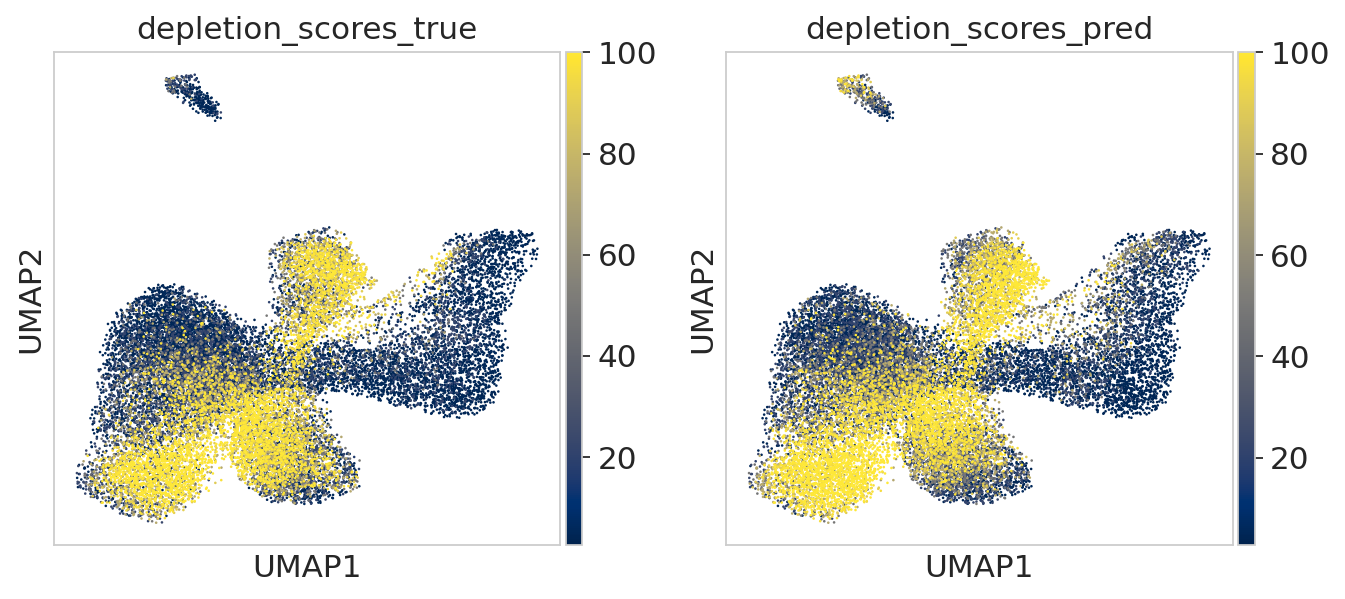

In [143]:
fig = sc.pl.umap(bdata_selection_ctrl, color=["depletion_scores_true", "depletion_scores_pred"], cmap="cividis", return_fig=True)
fig.savefig(os.path.join(fig_dir, "umap_depletion_fin.png"))

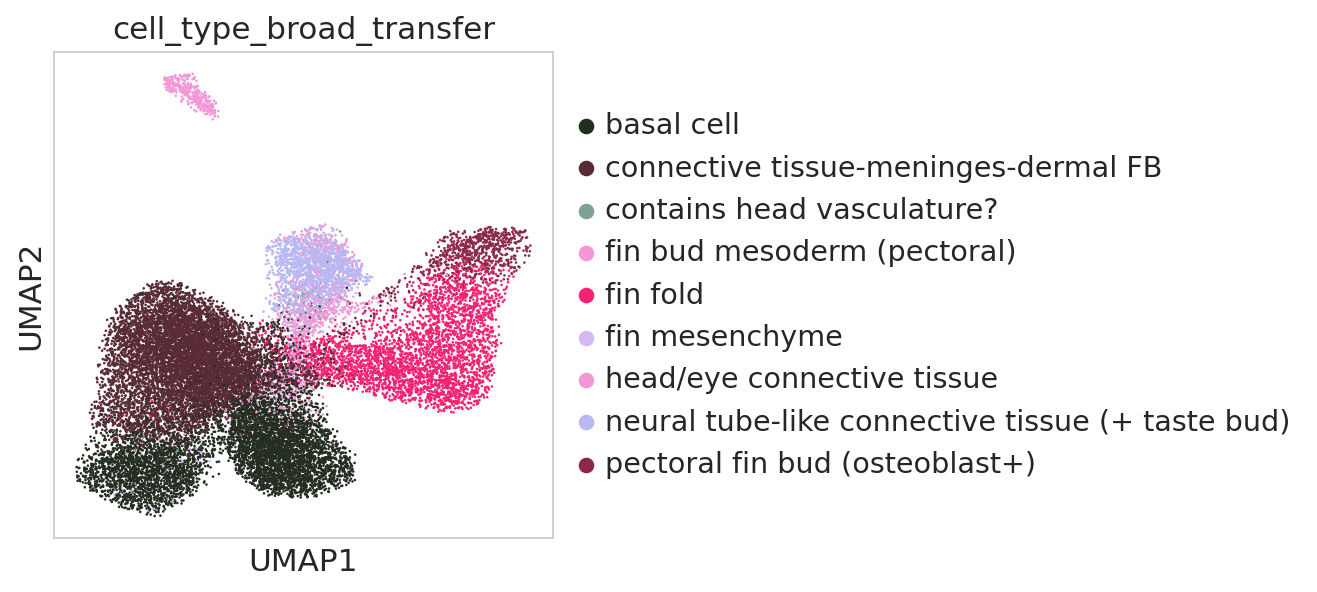

In [144]:
fig = sc.pl.umap(bdata_selection_ctrl, color=["cell_type_broad_transfer"], return_fig=True, palette=color_dict)
fig.savefig(os.path.join(fig_dir, "umap_depletion_fin_cell_types.png"))

In [145]:
bdata_selection_ctrl.obs[["depletion_scores_true", "depletion_scores_pred"]].corr()

depletion_scores_true  depletion_scores_pred
depletion_scores_true               1.000000               0.720355
depletion_scores_pred               0.720355               1.000000

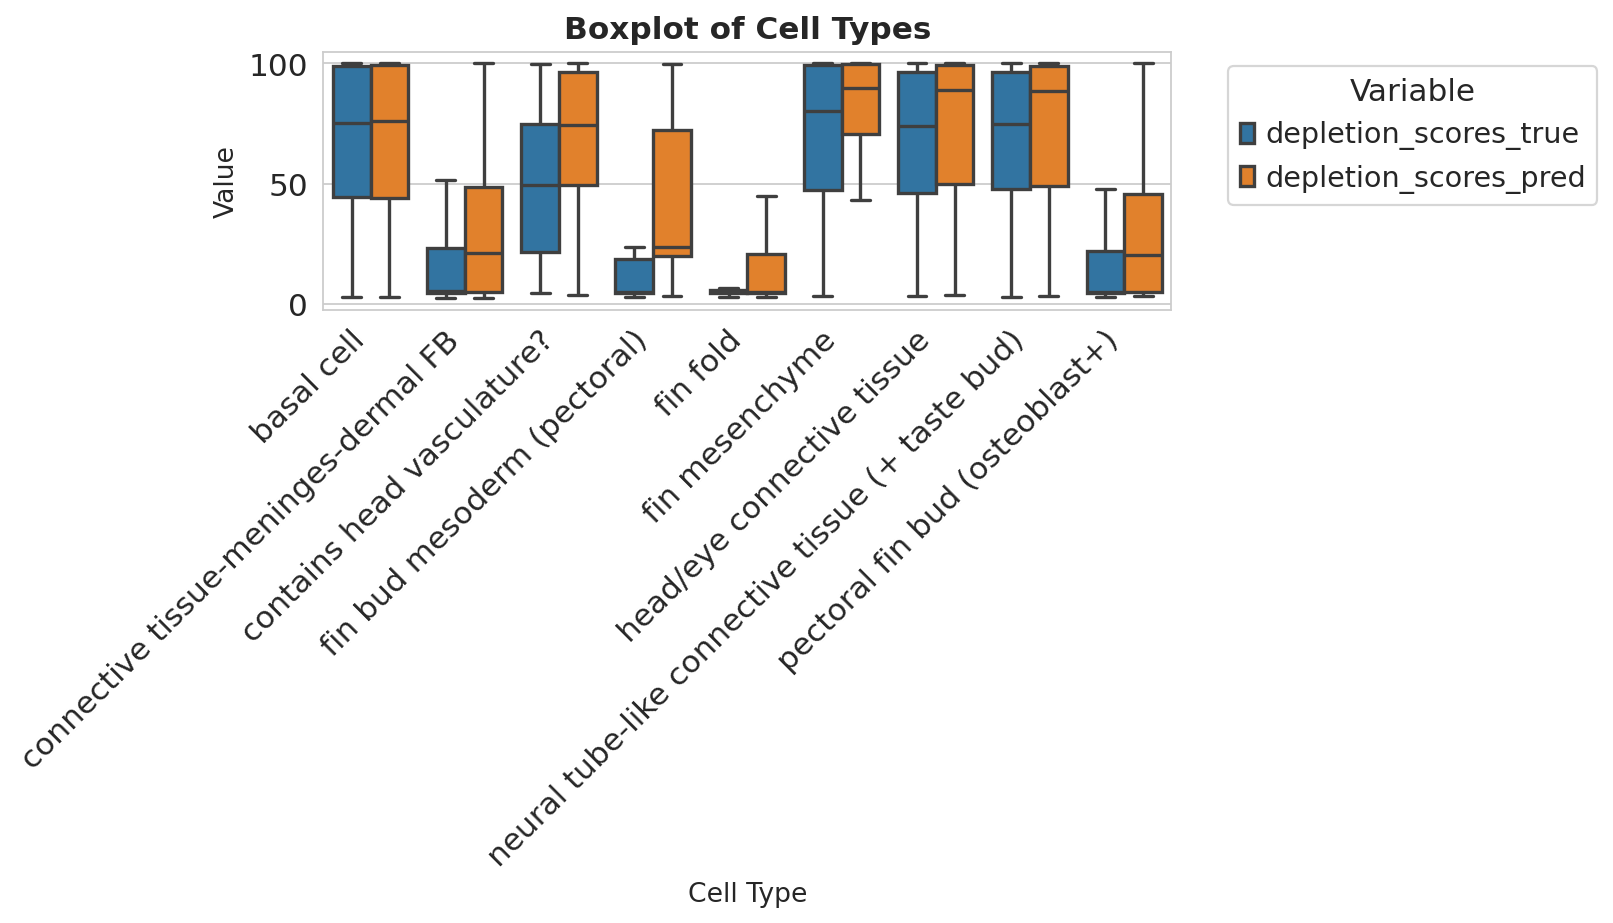

In [146]:
df_tmp = bdata_selection_ctrl.obs[["depletion_scores_true", "depletion_scores_pred", "cell_type_broad_transfer"]]
df_tmp = pd.melt(df_tmp, id_vars=["cell_type_broad_transfer"], value_vars=["depletion_scores_true", "depletion_scores_pred"])

# Set a better style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create the boxplot with enhancements
ax = sns.boxplot(
    data=df_tmp, 
    x="cell_type_broad_transfer", 
    y="value", 
    hue="variable",
    showfliers=False,  # Hide outliers for a cleaner look
    linewidth=1.5,  # Make box outlines slightly thicker
    dodge=True  # Separate the hues better
)

# Improve legend positioning
plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc="upper left")

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha="right")

# Improve axis labels and title
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Boxplot of Cell Types", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()


# Muscle cell

In [147]:
muscle_cts = list(adata[adata.obs["tissue"]=="Muscle"].obs["cell_type_broad"].unique())
bdata_selection = bdata[bdata.obs["cell_type_broad_transfer"].isin(muscle_cts)]
bdata_selection.obs = bdata_selection.obs.reset_index()

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [148]:

bdata_selection.obs["mode"] = bdata_selection.obs["mode"].astype(str)

# Get minimum sample count for downsampling
downsample_to = bdata_selection.obs["mode"].value_counts().reindex(["pred", "true"], fill_value=0).min()

# Proper indexing for AnnData (use boolean mask on .obs index)
bdata_selection_ctrl = bdata_selection[bdata_selection.obs["mode"] == "control"].copy()
bdata_selection_true = bdata_selection[bdata_selection.obs["mode"] == "true"].copy()
bdata_selection_pred = bdata_selection[bdata_selection.obs["mode"] == "pred"].copy()

# Subsample only if necessary
if bdata_selection_pred.n_obs > downsample_to:
    bdata_selection_pred = sc.pp.subsample(bdata_selection_pred, n_obs=downsample_to, copy=True)

if bdata_selection_true.n_obs > downsample_to:
    bdata_selection_true = sc.pp.subsample(bdata_selection_true, n_obs=downsample_to, copy=True)

bdata_selection_ctrl_true = ad.concat([bdata_selection_ctrl, bdata_selection_true])
bdata_selection_ctrl_pred = ad.concat([bdata_selection_ctrl, bdata_selection_pred])

rsc.pp.neighbors(bdata_selection_ctrl_true, use_rep="X_aligned")
rsc.pp.neighbors(bdata_selection_ctrl_pred, use_rep="X_aligned")

rsc.tl.umap(bdata_selection_ctrl_true)
rsc.tl.umap(bdata_selection_ctrl_pred)

bdata_selection_ctrl_true.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_true.obs["mode"] == "control", 0.0, 1.0
)
bdata_selection_ctrl_pred.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_pred.obs["mode"] == "control", 0.0, 1.0
)


/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [149]:
compute_depletion(bdata_selection_ctrl_pred)
compute_depletion(bdata_selection_ctrl_true)
bdata_selection_ctrl_pred.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_pred.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)
bdata_selection_ctrl_true.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_true.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)

In [150]:
df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_pred = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_pred[ct] = frac_depleted.values



df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_true = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_true[ct] = frac_depleted.values


/tmp/ipykernel_1329633/1086478450.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
/tmp/ipykernel_1329633/1086478450.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_s

In [151]:
rsc.pp.neighbors(bdata_selection_ctrl, use_rep="X_aligned")
rsc.tl.umap(bdata_selection_ctrl, min_dist=0.9)

In [152]:
bdata_selection_ctrl.obs["depletion_true"] = bdata_selection_ctrl_true.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_pred"] = bdata_selection_ctrl_pred.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_scores_true"] = bdata_selection_ctrl_true.obs["percentiles"]
bdata_selection_ctrl.obs["depletion_scores_pred"] = bdata_selection_ctrl_pred.obs["percentiles"]


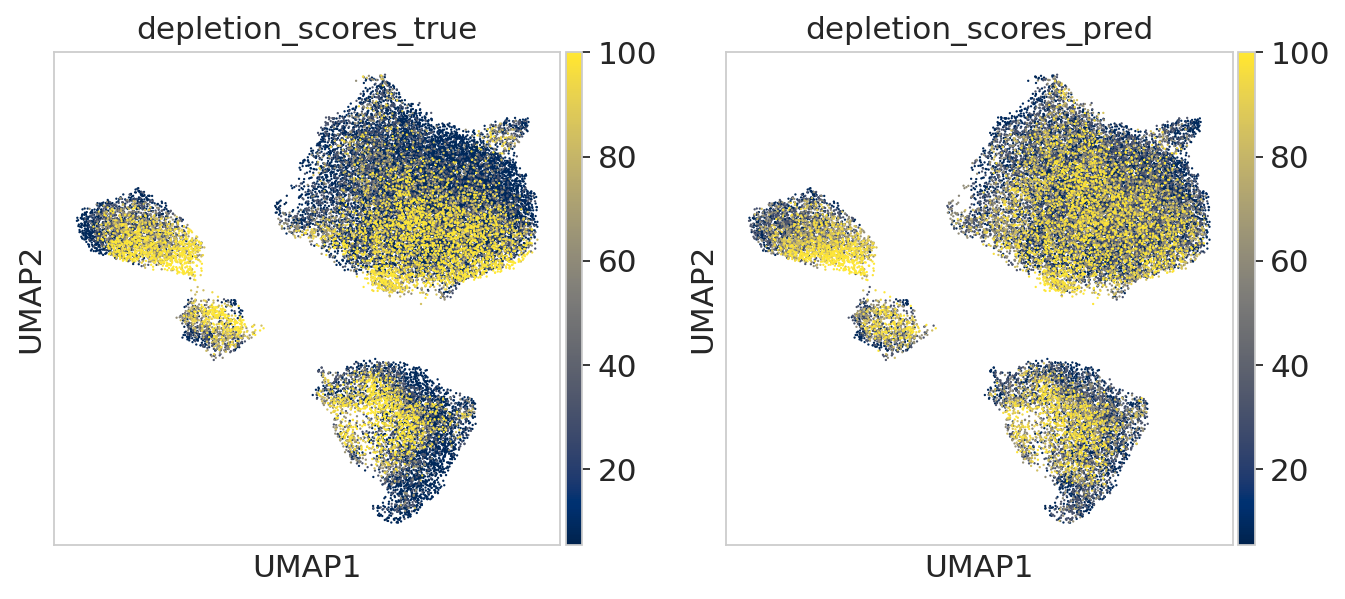

In [153]:
fig = sc.pl.umap(bdata_selection_ctrl, color=["depletion_scores_true", "depletion_scores_pred"], cmap="cividis", return_fig=True)
fig.savefig(os.path.join(fig_dir, "umap_depletion_muscle_cell.png"))

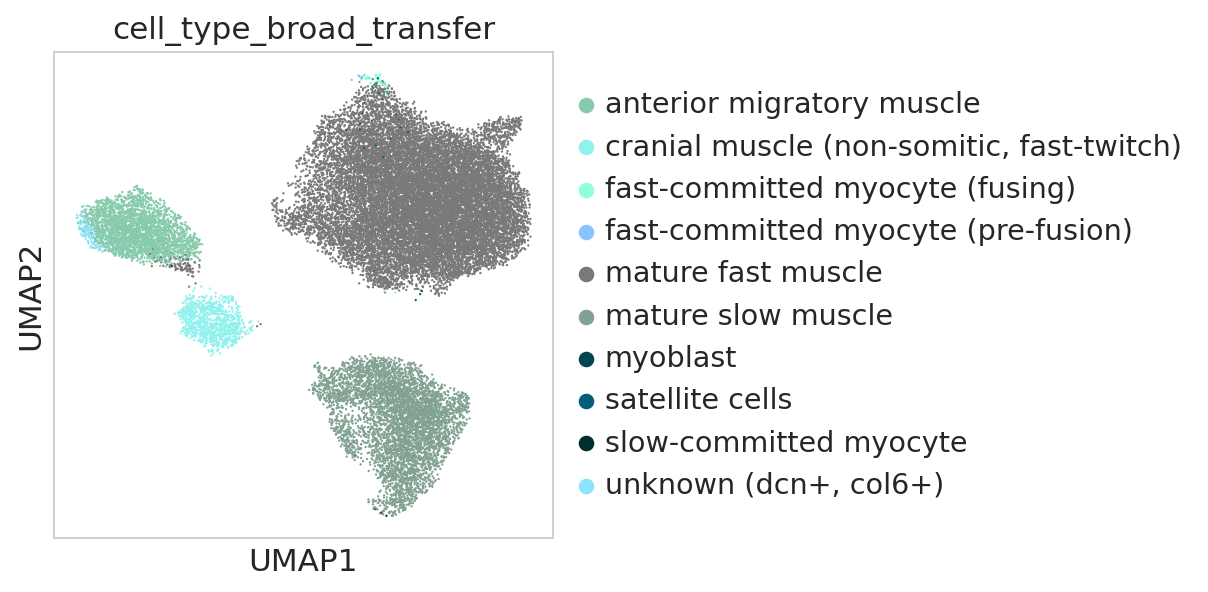

In [154]:
fig = sc.pl.umap(bdata_selection_ctrl, color=["cell_type_broad_transfer"], return_fig=True, palette=color_dict)
fig.savefig(os.path.join(fig_dir, "umap_depletion_muscle_cell_types.png"))

In [155]:
bdata_selection_ctrl.obs[["depletion_scores_true", "depletion_scores_pred"]].corr()

depletion_scores_true  depletion_scores_pred
depletion_scores_true               1.000000               0.604649
depletion_scores_pred               0.604649               1.000000

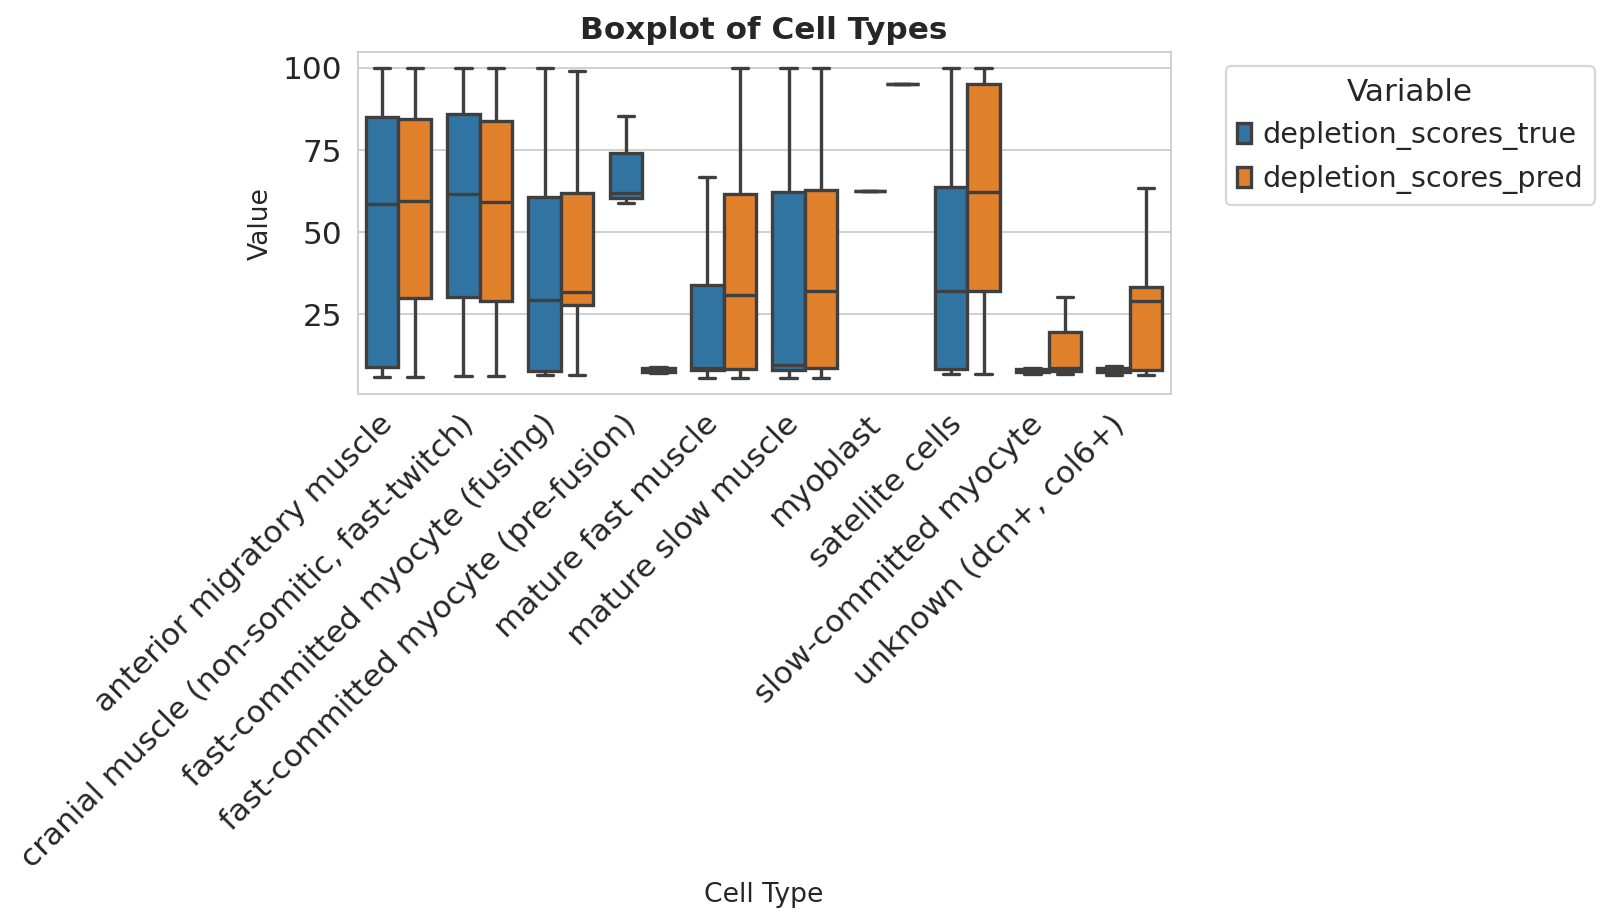

In [156]:
df_tmp = bdata_selection_ctrl.obs[["depletion_scores_true", "depletion_scores_pred", "cell_type_broad_transfer"]]
df_tmp = pd.melt(df_tmp, id_vars=["cell_type_broad_transfer"], value_vars=["depletion_scores_true", "depletion_scores_pred"])

# Set a better style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create the boxplot with enhancements
ax = sns.boxplot(
    data=df_tmp, 
    x="cell_type_broad_transfer", 
    y="value", 
    hue="variable",
    showfliers=False,  # Hide outliers for a cleaner look
    linewidth=1.5,  # Make box outlines slightly thicker
    dodge=True  # Separate the hues better
)

# Improve legend positioning
plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc="upper left")

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha="right")

# Improve axis labels and title
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Boxplot of Cell Types", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()


In [170]:
df_depl_normalized

true      pred
basal cell                                        0.284506  0.479610
connective tissue-meninges-dermal FB              1.524447  1.819138
contains head vasculature?                        0.140852  0.345555
fin bud mesoderm (pectoral)                       2.182181  0.935209
fin fold                                          2.073586  3.142245
fin mesenchyme                                    0.531302  0.193104
head/eye connective tissue                        0.207568  0.108892
neural tube-like connective tissue (+ taste bud)  0.175981  0.128355
pectoral fin bud (osteoblast+)                    1.879578  1.847892

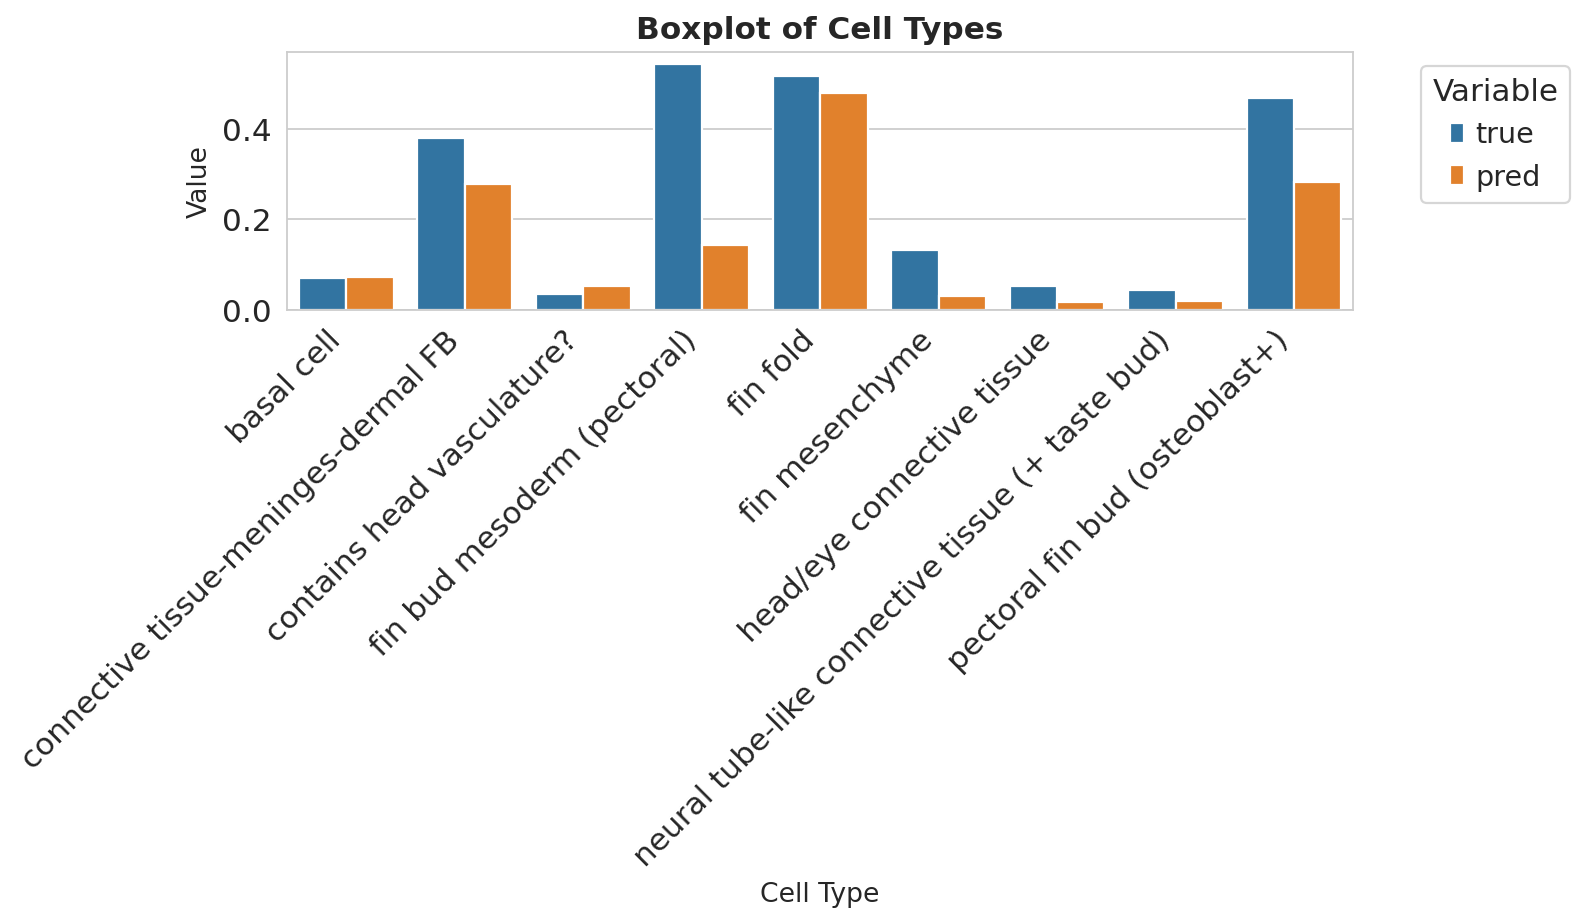

In [182]:
df_depletion_fracs["cell_type"] = df_depletion_fracs.index
df_tmp = pd.melt(df_depletion_fracs, value_vars=["true", "pred"], id_vars=["cell_type"])
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create the boxplot with enhancements
ax = sns.barplot(
    data=df_tmp, 
    x="cell_type", 
    y="value", 
    hue="variable",
    )

# Improve legend positioning
plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc="upper left")

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha="right")

# Improve axis labels and title
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Boxplot of Cell Types", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()
